In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import os
from tqdm import tqdm

In [5]:
# 1. 定義自訂的 Dataset
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.labels.iloc[idx, 0])
        image = Image.open(img_name).convert('L')  # 轉換為灰階
        label = int(self.labels.iloc[idx, 1])
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

# 2. 定義資料轉換
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # 因為是灰階圖像，只有一個通道
])

# 3. 創建訓練和驗證數據集
full_dataset = CustomImageDataset(csv_file='aoi/train.csv', img_dir='aoi/train_images', transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 4. 定義模型
# VGG16
class CustomVGG16(nn.Module):
    def __init__(self, num_classes=6):
        super(CustomVGG16, self).__init__()
        self.model = models.vgg16(pretrained=True)
        self.model.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)  # 修改第一層以適應單通道灰階圖像
        self.model.classifier[6] = nn.Linear(4096, num_classes)  # 修改輸出層

    def forward(self, x):
        return self.model(x)
    
## ResNet18
class CustomResNet18(nn.Module):
    def __init__(self, num_classes=6):
        super(CustomResNet18, self).__init__()
        self.model = models.resnet18(pretrained=True)   # pretrained -> weight (版本改變)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # 修改第一層以適應單通道灰階圖像
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)  # 修改輸出層

    def forward(self, x):
        return self.model(x)

# 選擇模型
# model = CustomVGG16()
model = CustomResNet18()

# 5. 設定訓練參數
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 6. 訓練模型並紀錄 train 和 val 的 loss
# 訓練模型並紀錄 train 和 val 的 loss
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    model.train()
    train_losses = []
    val_losses = []
    # 只保留val_loss最小的模型
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        running_train_loss = 0.0
        running_val_loss = 0.0

        # 訓練階段
        model.train()
        train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
        for inputs, labels in train_progress:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item() * inputs.size(0)
        
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # 驗證階段
        model.eval()
        val_progress = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)
        with torch.no_grad():
            for inputs, labels in val_progress:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
                
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        # 保存val_loss最小的模型
        if epoch_val_loss < best_val_loss:
            
            # 先移除舊的模型
            old_model_path = f'best_model_{best_val_loss:.2f}.pth'
            if os.path.exists(old_model_path):
                os.remove(old_model_path)
            
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), f'best_model_{epoch_val_loss:.2f}.pth')
            

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

    return train_losses, val_losses


c:\ProgramData\anaconda3\envs\ml-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\envs\ml-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=40)


c:\ProgramData\anaconda3\envs\ml-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\envs\ml-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/40, Train Loss: 0.6708, Val Loss: 0.7739


Epoch 2/40, Train Loss: 0.4390, Val Loss: 0.9639


Epoch 3/40, Train Loss: 0.3243, Val Loss: 0.3315


Epoch 4/40, Train Loss: 0.2520, Val Loss: 1.1038


Epoch 5/40, Train Loss: 0.2869, Val Loss: 0.4101


Epoch 6/40, Train Loss: 0.1787, Val Loss: 0.2966


Epoch 7/40, Train Loss: 0.1809, Val Loss: 0.2725


Epoch 8/40, Train Loss: 0.1541, Val Loss: 0.1568


Epoch 9/40, Train Loss: 0.1876, Val Loss: 0.2190


Epoch 10/40, Train Loss: 0.1257, Val Loss: 0.1265


Epoch 11/40, Train Loss: 0.1028, Val Loss: 0.2718


Epoch 12/40, Train Loss: 0.0970, Val Loss: 0.4168


Epoch 13/40, Train Loss: 0.1311, Val Loss: 0.2355


Epoch 14/40, Train Loss: 0.1183, Val Loss: 0.1800


Epoch 15/40, Train Loss: 0.0735, Val Loss: 0.1289


Epoch 16/40, Train Loss: 0.0603, Val Loss: 0.1602


Epoch 17/40, Train Loss: 0.0963, Val Loss: 0.5145


Epoch 18/40, Train Loss: 0.1105, Val Loss: 0.1825


Epoch 19/40, Train Loss: 0.0581, Val Loss: 0.0967


Epoch 20/40, Train Loss: 0.0326, Val Loss: 0.1265


Epoch 21/40, Train Loss: 0.0574, Val Loss: 0.1494


Epoch 22/40, Train Loss: 0.0451, Val Loss: 0.0962


Epoch 23/40, Train Loss: 0.0252, Val Loss: 0.1131


Epoch 24/40, Train Loss: 0.0353, Val Loss: 0.1200


Epoch 25/40, Train Loss: 0.0613, Val Loss: 0.1473


Epoch 26/40, Train Loss: 0.0486, Val Loss: 0.1145


Epoch 27/40, Train Loss: 0.0364, Val Loss: 0.1045


Epoch 28/40, Train Loss: 0.0468, Val Loss: 0.1336


Epoch 29/40, Train Loss: 0.0260, Val Loss: 0.1339


Epoch 30/40, Train Loss: 0.0426, Val Loss: 0.1353


Epoch 31/40, Train Loss: 0.0345, Val Loss: 0.0898


Epoch 32/40, Train Loss: 0.0230, Val Loss: 0.1900


Epoch 33/40, Train Loss: 0.0421, Val Loss: 0.1555


Epoch 34/40, Train Loss: 0.0260, Val Loss: 0.1513


Epoch 35/40, Train Loss: 0.0313, Val Loss: 0.1282


Epoch 36/40, Train Loss: 0.0621, Val Loss: 0.1023


Epoch 37/40, Train Loss: 0.0202, Val Loss: 0.1152


Epoch 38/40, Train Loss: 0.0121, Val Loss: 0.1274


Epoch 39/40, Train Loss: 0.0089, Val Loss: 0.0919


Epoch 40/40, Train Loss: 0.0054, Val Loss: 0.0728


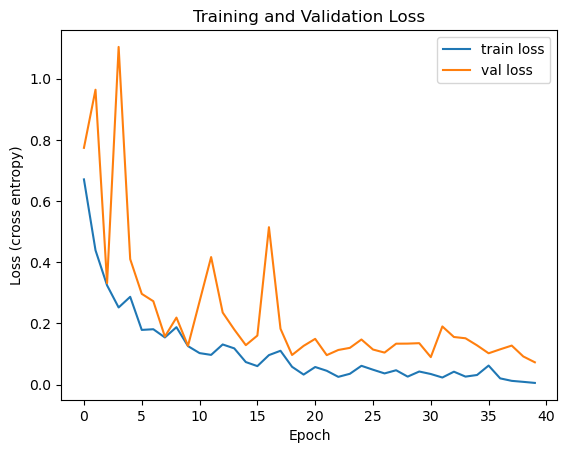

In [3]:
# 7. 繪製 loss 曲線
import matplotlib.pyplot as plt

plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss (cross entropy)')
plt.title('Training and Validation Loss')
plt.show()

## 預測測試集

In [4]:
# 8. 載入最佳模型並進行測試
# 沒有label的測試集
test_dataset = CustomImageDataset(csv_file='aoi/test.csv', img_dir='aoi/test_images', transform=transform)


In [14]:
# 測試圖片位於 aoi/test_images 目錄下
class TestImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.image_files = os.listdir(img_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.image_files[idx])
        image = Image.open(img_name).convert('L')  # 轉換為灰階
        
        if self.transform:
            image = self.transform(image)
            
        return image, self.image_files[idx]

# 定義轉換
test_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [5]:
# 創建測試數據集
test_dataset = TestImageDataset(img_dir='aoi/test_images', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 載入最佳模型 <<<
best_val_loss = sorted(val_losses)[0]
model.load_state_dict(torch.load(f'best_model_{best_val_loss:.2f}.pth'))

# 模型進入評估模式
model.eval()

# 預測測試集
predictions = []
image_names = []

with torch.no_grad():
    for inputs, names in tqdm(test_loader, desc="Predicting"):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        image_names.extend(names)

# 組合結果
results = pd.DataFrame({'ID': image_names, 'Label': predictions})

# 輸出到 csv
results.to_csv('test_predictions.csv', index=False)


C:\Users\eric\AppData\Local\Temp\ipykernel_32232\4066853233.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_{best_val_loss

## 模型特徵可視化

### train set 的 t-SNE

In [6]:
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# 使用已訓練的模型
model = CustomResNet18()
model.load_state_dict(torch.load('best_model_0.07.pth'))
model.eval()

# 移除最後一層的分類層
feature_extractor = nn.Sequential(*list(model.children())[:-1])
feature_extractor = feature_extractor.to(device)

# 提取特徵
features = []
labels = []

with torch.no_grad():
    for inputs, label in tqdm(val_loader, desc="Extracting Features"):
        inputs = inputs.to(device)
        output = feature_extractor(inputs)
        output = output.view(output.size(0), -1)  # 攤平特徵
        features.append(output.cpu().numpy())
        labels.append(label.numpy())

features = np.concatenate(features, axis=0)
labels = np.concatenate(labels, axis=0)


C:\Users\eric\AppData\Local\Temp\ipykernel_23176\3335815614.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model_0.07.pth'))
Extr

In [7]:
features.shape

(506, 262144)

In [8]:
labels.shape

(506,)

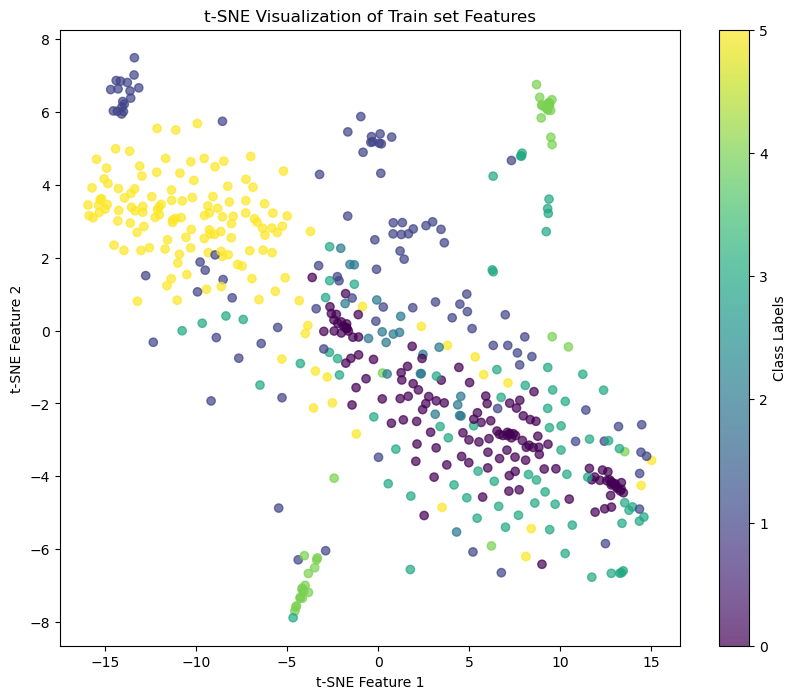

In [12]:
# 使用 t-SNE 進行降維
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(features)

# 繪製 t-SNE 圖
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Class Labels')
plt.title('t-SNE Visualization of Train set Features')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()



### test set 的 t-SNE

In [19]:
# test set 的 t-SNE

# 載入test set
test_dataset = TestImageDataset(img_dir='aoi/test_images', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
test_features = []
test_predictions = pd.read_csv('test_predictions-3.csv')['Label'].to_list()

with torch.no_grad():
    for inputs, names in tqdm(test_loader, desc="Extracting Features"):
        inputs = inputs.to(device)
        output = feature_extractor(inputs)
        output = output.view(output.size(0), -1)  # 攤平特徵
        test_features.append(output.cpu().numpy())
        
test_features = np.concatenate(test_features, axis=0)

Extracting Features: 100%|██████████| 317/317 [00:51<00:00,  6.20it/s]


In [ ]:
# 使用 t-SNE 進行降維
tsne_test_features = tsne.fit_transform(test_features)

# 繪製 t-SNE 圖
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_test_features[:, 0], tsne_test_features[:, 1], c=test_predictions, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Class Labels')
plt.title('t-SNE Visualization of Test set Features')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.show()